We first prepare the dataset by cleaning and preprocessing the text of each review into list of tokens

In [1]:
import re
import sys
import string
import itertools

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

PRINTABLE = set(string.printable)
STOPLIST = set(stopwords.words("english")) | {"'ve", "'m", "'s", "'re", "'d", "'ll"}

Read **train** and **unlabeld** into dataframes. Only **train** comes with class labels

In [2]:
train = pd.read_csv("labeledTrainData.tsv",
                    delimiter="\t",
                    header=0,
                    quoting=3)

unlabeled = pd.read_csv("unlabeledTrainData.tsv",
                       delimiter="\t",
                       header=0,
                       quoting=3)

There is an interesting oservation for this dataset: 

## Extremely long or short reviews tend to be more positive and medium-length reviews

In [3]:
n_chs = train["review"].map(len)
n_words = train["review"].map(lambda s: len(s.split()))

y = train["sentiment"]

review
[10, 91]       0.560205
(91, 120]      0.504791
(120, 134]     0.469540
(134, 151]     0.479124
(151, 174]     0.490243
(174, 206]     0.467992
(206, 252]     0.492567
(252, 325]     0.492759
(325, 458]     0.501007
(458, 2470]    0.539695
Name: sentiment, dtype: float64


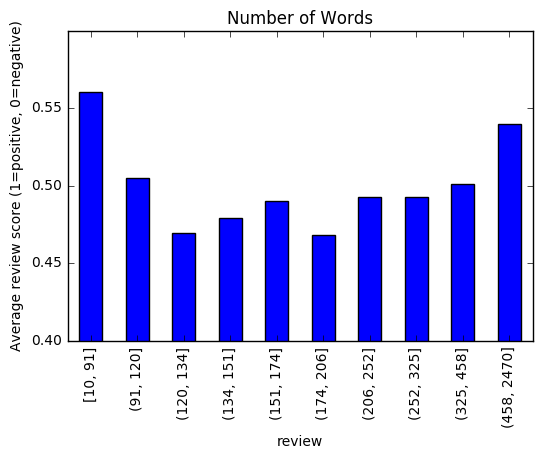

In [4]:
factor = pd.qcut(n_words, 10)
df = y.groupby(factor).mean()
print df
df.plot(kind="bar")
plt.title("Number of Words")
plt.ylabel("Average review score (1=positive, 0=negative)")
plt.ylim([0.4, 0.6])
plt.show()

review
[54, 514]          0.561775
(514, 667]         0.491047
(667, 745]         0.485235
(745, 847]         0.485152
(847, 983]         0.466640
(983, 1164]        0.475271
(1164, 1435]       0.483254
(1435, 1860]       0.499599
(1860, 2626.1]     0.508807
(2626.1, 13710]    0.543200
Name: sentiment, dtype: float64


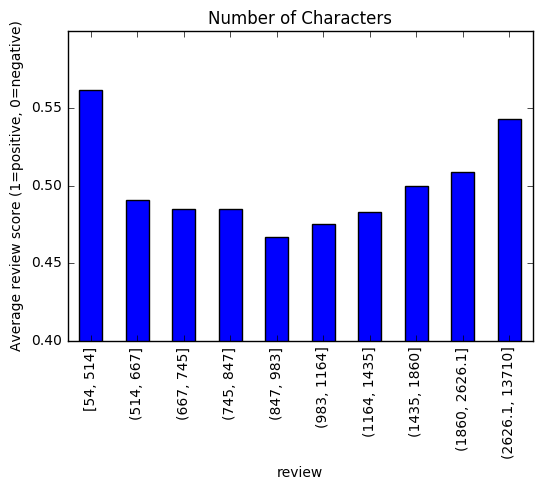

In [5]:
factor = pd.qcut(n_chs, 10)
df = y.groupby(factor).mean()
print df
df.plot(kind="bar")
plt.title("Number of Characters")
plt.ylabel("Average review score (1=positive, 0=negative)")
plt.ylim([0.4, 0.6])
plt.show()

Define utility functions for cleaning and preprocessing text

In [6]:
def clean_text(text):
    """Remove tags from text."""
    text = text.replace("\n", " ").replace("\r", " ")
    text = re.sub(r"https?://[^\s\"\']+", "URL", text)
    text = re.sub(r"< *br *>", " ", text)
    text = re.sub(r"< *br */ *>", " ", text)
    text = re.sub(r"[=\+\\*\[\]\(\)&%\$#@\^]", "", text)
    text = re.sub(r"\d+", "NUM", text)
    text = text[1:-1]
    
    text = filter(lambda ch: ch in PRINTABLE, text)
    
    return text

def process_stemming_pos(text,
                        pos_filter=set("VNJ"),
                        stemming=True,
                        stoplist=STOPLIST,
                        sent_tokenize=sent_tokenize,
                        word_tokenize=word_tokenize,
                        lemmantize=WordNetLemmatizer):


    lemmatize_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ}
    wl = WordNetLemmatizer()

    def stem_word_pos_pair(word, pos):
        v = pos[0].upper()
        if v != "V" and v != "N" and v != "J":
            return word, pos
        else:
            return wl.lemmatize(word, lemmatize_map[v]), pos

    try:
        sents_tokens_pos = [pos_tag(word_tokenize(sent))
                            for sent in sent_tokenize(text)]
        tokens_pos = list(itertools.chain(*sents_tokens_pos))

        if stoplist is not None:
            tokens_pos = filter(lambda pair: pair[0] not in stoplist, tokens_pos)
        if stemming:
            tokens_pos = [stem_word_pos_pair(*pair) for pair in tokens_pos]
        if pos_filter is not None:
            tokens_pos = filter(lambda pair: pair[1][0] in pos_filter, tokens_pos)

        if len(tokens_pos) == 0:
            return ""
        text = " ".join(zip(*tokens_pos)[0])
    except Exception as inst:
        print "semantic_processing: %s\ninput: %r" % (inst, text)
        sys.exit(1)

    return text    

Process raw text of labeled (**train**) and unlabeled (**unlabeled**) reviews

In [7]:
train_sents = []
for i in range(len(train)):
    if i % 5000 == 0:
        print i
    r = process_stemming_pos(clean_text(train["review"][i]), pos_filter=None, stemming=False, stoplist=None)
    train_sents.append(r)
     
unlabeled_sents = []
for i in range(len(unlabeled)):
    if i % 5000 == 0:
        print i
    r = process_stemming_pos(clean_text(unlabeled["review"][i]), pos_filter=None, stemming=False, stoplist=None)
    unlabeled_sents.append(r) 

0
5000
10000
15000
20000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


Save the results:

In [8]:
import pickle
pickle.dump(train_sents, open("train_sents.pickle", "w"))
pickle.dump(unlabeled_sents, open("unlabeled_sents.pickle", "w"))

Repeat the process, but perform verb stemming

In [9]:
train_sents_stem = []
for i in range(len(train)):
    if i % 5000 == 0:
        print i
    r = process_stemming_pos(clean_text(train["review"][i]), pos_filter=None, stemming=True, stoplist=None)
    train_sents_stem.append(r)
     
unlabeled_sents_stem = []
for i in range(len(unlabeled)):
    if i % 5000 == 0:
        print i
    r = process_stemming_pos(clean_text(unlabeled["review"][i]), pos_filter=None, stemming=True, stoplist=None)
    unlabeled_sents_stem.append(r)  

0
5000
10000
15000
20000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [10]:
pickle.dump(train_sents_stem, open("train_sents_stem.pickle", "w"))
pickle.dump(unlabeled_sents_stem, open("unlabeled_sents_stem.pickle", "w"))

Take a look at the processed text:

In [11]:
# Original
train["review"].iloc[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [12]:
# Processed
train_sents[0]

"With all this stuff going down at the moment with MJ i 've started listening to his music , watching the odd documentary here and there , watched The Wiz and watched Moonwalker again . Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent . Moonwalker is part biography , part feature film which i remember going to see at the cinema when it was originally released . Some of it has subtle messages about MJ 's feeling towards the press and also the obvious message of drugs are bad m'kay . Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring . Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him . The actual feature film bit when it finally starts is only

In [13]:
# Processed (Verb stemmed)
train_sents_stem[0]

u"With all this stuff go down at the moment with MJ i 've start listen to his music , watch the odd documentary here and there , watch The Wiz and watch Moonwalker again . Maybe i just want to get a certain insight into this guy who i think be really cool in the eighty just to maybe make up my mind whether he be guilty or innocent . Moonwalker be part biography , part feature film which i remember go to see at the cinema when it be originally release . Some of it have subtle message about MJ 's feeling towards the press and also the obvious message of drug be bad m'kay . Visually impressive but of course this be all about Michael Jackson so unless you remotely like MJ in anyway then you be go to hate this and find it bore . Some may call MJ an egotist for consent to the making of this movie BUT MJ and most of his fan would say that he make it for the fan which if true be really nice of him . The actual feature film bit when it finally start be only on for NUM minute or so exclude the S